In [2]:
import argparse, json
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from tensorboardX import SummaryWriter

In [3]:
# Training settings
parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                    help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                    help='input batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=20, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--lr', type=float, default=0.01, metavar='LR',
                    help='learning rate (default: 0.01)')
parser.add_argument('--momentum', type=float, default=0.5, metavar='M',
                    help='SGD momentum (default: 0.5)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
args = parser.parse_args([]) # default: taken from sys.argv
args.cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)


kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('MNIST_data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,)) # (mean, std)
                   ])),
    batch_size=args.batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('MNIST_data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,)) 
                   ])),
    batch_size=args.test_batch_size, shuffle=True, **kwargs)

## Models

### 2FC

In [38]:
class CNN_2FC(nn.Module):
    def __init__(self):
        super(CNN_2FC, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.max_pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d() # p=0.5 by default
        self.max_pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.max_pool1(self.conv1(x))) # (input, kernel_size)
        x = F.relu(self.max_pool2(self.conv2_drop(self.conv2(x)),))
        x = x.view(-1, 320) # flatten
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

model = CNN_2FC()
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
num_params = sum([np.prod(p.size()) for p in model_parameters])
print('model params:', num_params)
# if args.cuda:
#     model.cuda()

optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

def train(epoch):
    model.train() # set to training mode
    for batch_idx, (data, target) in enumerate(train_loader):
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target) # not storing gradients
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

def trained_epoch(epoch):
    model.eval()# set to evaluation mode
    trained_loss = 0
    correct = 0
    for data, target in train_loader:
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target) # no intermediate states will be saved
        output = model(data)
        trained_loss += F.nll_loss(output, target, size_average=False).data[0] # want to average loss over entire test set, not just minibatch
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()
    
    trained_loss /= len(train_loader.dataset)
    trained_accuracy = correct / len(train_loader.dataset)
    writer.add_scalar('data/train_loss', trained_loss, epoch) # try add_scalars() later
    writer.add_scalar('data/train_accuracy', trained_accuracy, epoch)
    print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        trained_loss, correct, len(train_loader.dataset),
        100. * trained_accuracy))
            
def test(epoch):
    model.eval()# set to evaluation mode
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target) # no intermediate states will be saved
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data[0] # want to average loss over entire test set, not just minibatch
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    test_loss /= len(test_loader.dataset)
    test_accuracy = correct / len(test_loader.dataset)
    writer.add_scalar('data/test_loss', test_loss, epoch) # try add_scalars() later
    writer.add_scalar('data/test_accuracy', test_accuracy, epoch)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * test_accuracy))
    
    writer.export_scalars_to_json("./CNN_2FC.json")

model params: 21840


### 3FC

In [57]:
extra_hidden = 44
class CNN_3FC(nn.Module):
    def __init__(self):
        super(CNN_3FC, self).__init__() # input: 28*28
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5) # 24*24*10
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5) # 8*8*20
        self.conv2_drop = nn.Dropout2d() # p=0.5 by default # 8*8*20
        self.fc1 = nn.Linear(320, extra_hidden) # total of 16500 params in FC
        self.fc2 = nn.Linear(extra_hidden, extra_hidden)
        self.fc3 = nn.Linear(extra_hidden, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) # 12*12*10
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2)) # 4*4*20 but half of params are 0
        x = x.view(-1, 320) # flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

model = CNN_3FC()
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
num_params = sum([np.prod(p.size()) for p in model_parameters])
print('number of model params:', num_params)
if args.cuda:
    model.cuda()

optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

def train(epoch):
    model.train() # set to training mode
    for batch_idx, (data, target) in enumerate(train_loader):
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target) # not storing gradients
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

def trained_epoch(epoch):
    model.eval()# set to evaluation mode
    trained_loss = 0
    correct = 0
    for data, target in train_loader:
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target) # no intermediate states will be saved
        output = model(data)
        trained_loss += F.nll_loss(output, target, size_average=False).data[0] # want to average loss over entire test set, not just minibatch
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()
    
    trained_loss /= len(train_loader.dataset)
    trained_accuracy = correct / len(train_loader.dataset)
    writer.add_scalar('data/deep_train_loss', trained_loss, epoch) # try add_scalars() later
    writer.add_scalar('data/deep_train_accuracy', trained_accuracy, epoch)
    print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        trained_loss, correct, len(train_loader.dataset),
        100. * trained_accuracy))
            
def test(epoch):
    model.eval()# set to evaluation mode
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target) # no intermediate states will be saved
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data[0] # want to average loss over entire test set, not just minibatch
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    test_loss /= len(test_loader.dataset)
    test_accuracy = correct / len(test_loader.dataset)
    writer.add_scalar('data/deep_test_loss', test_loss, epoch) # try add_scalars() later
    writer.add_scalar('data/deep_test_accuracy', test_accuracy, epoch)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * test_accuracy))
    
    writer.export_scalars_to_json("./CNN_3FC.json")

number of model params: 22334


### 5FC

In [18]:
extra_hidden = 37
name = '5FC'
class CNN_5FC(nn.Module):
    def __init__(self):
        super(CNN_5FC, self).__init__() # input: 28*28
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5) # 24*24*10
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5) # 8*8*20
        self.conv2_drop = nn.Dropout2d() # p=0.5 by default # 8*8*20
        self.fc1 = nn.Linear(320, extra_hidden) # total of 16500 params in FC
        self.fc2 = nn.Linear(extra_hidden, extra_hidden)
        self.fc3 = nn.Linear(extra_hidden, extra_hidden)
        self.fc4 = nn.Linear(extra_hidden, extra_hidden)
        self.fc5 = nn.Linear(extra_hidden, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) # 12*12*10
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2)) # 4*4*20 but half of params are 0
        x = x.view(-1, 320) # flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.dropout(x, training=self.training)
        x = self.fc5(x)
        return F.log_softmax(x, dim=1)

model = CNN_5FC()
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
num_params = sum([np.prod(p.size()) for p in model_parameters])
print('number of model params:', num_params)
if args.cuda:
    model.cuda()

optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

def train(epoch):
    model.train() # set to training mode
    for batch_idx, (data, target) in enumerate(train_loader):
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target) # not storing gradients
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

def trained_epoch(epoch):
    model.eval()# set to evaluation mode
    trained_loss = 0
    correct = 0
    for data, target in train_loader:
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target) # no intermediate states will be saved
        output = model(data)
        trained_loss += F.nll_loss(output, target, size_average=False).data[0] # want to average loss over entire test set, not just minibatch
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()
    
    trained_loss /= len(train_loader.dataset)
    trained_accuracy = correct / len(train_loader.dataset)
    writer.add_scalar('{}/deep_train_loss'.format(name), trained_loss, epoch) # try add_scalars() later
    writer.add_scalar('{}/deep_train_accuracy'.format(name), trained_accuracy, epoch)
    print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        trained_loss, correct, len(train_loader.dataset),
        100. * trained_accuracy))
            
def test(epoch):
    model.eval()# set to evaluation mode
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target) # no intermediate states will be saved
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data[0] # want to average loss over entire test set, not just minibatch
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    test_loss /= len(test_loader.dataset)
    test_accuracy = correct / len(test_loader.dataset)
    writer.add_scalar('{}/deep_test_loss'.format(name), test_loss, epoch) # try add_scalars() later
    writer.add_scalar('{}/deep_test_accuracy'.format(name), test_accuracy, epoch)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * test_accuracy))
    
    writer.export_scalars_to_json("./CNN_{}.json".format(name))

number of model params: 21755


In [35]:
for epoch in range(1, args.epochs + 1):
    train(epoch)
    trained_epoch(epoch)
    test(epoch)
writer.close()

In [39]:
# need to comment out model's cuda() before writing graph
with SummaryWriter(comment='MNIST_2FC') as w:
    dummy_input = Variable(torch.rand(1000, 1, 28, 28))
    w.add_graph(model, (dummy_input, ))

# Plot loss and accuracy

In [41]:
model_logs = {}
for model_id in [2,3,5]:
    data = json.load(open('CNN_{}FC.json'.format(model_id)))
    model_logs[model_id] = {'loss': np.array(data['train_loss'])[:,2],
                           'accuracy': np.array(data['train_accuracy'])[:,2]}

In [36]:
len(model_logs[2]['loss'])

20

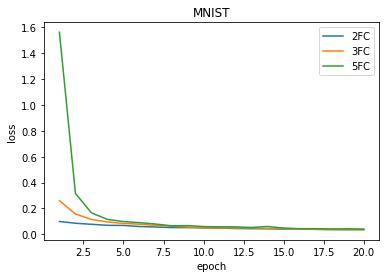

In [46]:
mode = 'loss'
x = [i+1 for i in range(len(model_logs[2][mode]))]
acc_2FC, = plt.plot(x, model_logs[2][mode], label='2FC')
acc_3FC, = plt.plot(x, model_logs[3][mode], label='3FC')
acc_5FC, = plt.plot(x, model_logs[5][mode], label='5FC')
plt.legend(handles=[acc_2FC, acc_3FC, acc_5FC])
plt.xlabel('epoch')
plt.ylabel(mode)
plt.title('MNIST')
plt.savefig('{}.png'.format(mode))
plt.show()

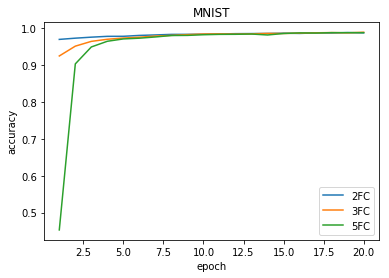

In [47]:
mode = 'accuracy'
x = [i+1 for i in range(len(model_logs[2][mode]))]
acc_2FC, = plt.plot(x, model_logs[2][mode], label='2FC')
acc_3FC, = plt.plot(x, model_logs[3][mode], label='3FC')
acc_5FC, = plt.plot(x, model_logs[5][mode], label='5FC')
plt.legend(handles=[acc_2FC, acc_3FC, acc_5FC])
plt.xlabel('epoch')
plt.ylabel(mode)
plt.title('MNIST')
plt.savefig('{}.png'.format(mode))
plt.show()